In [1]:
#import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.models import Model
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Conv2D ,Flatten,Dropout,MaxPool2D, BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
import keras as k
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.3)

In [3]:
train_generator = train_datagen.flow_from_directory(
    '../input/satellite-image-classification/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='training'
  )

Found 3942 images belonging to 4 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
     '../input/satellite-image-classification/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'
    
  )

Found 1689 images belonging to 4 classes.


Found 5631 files belonging to 4 classes.


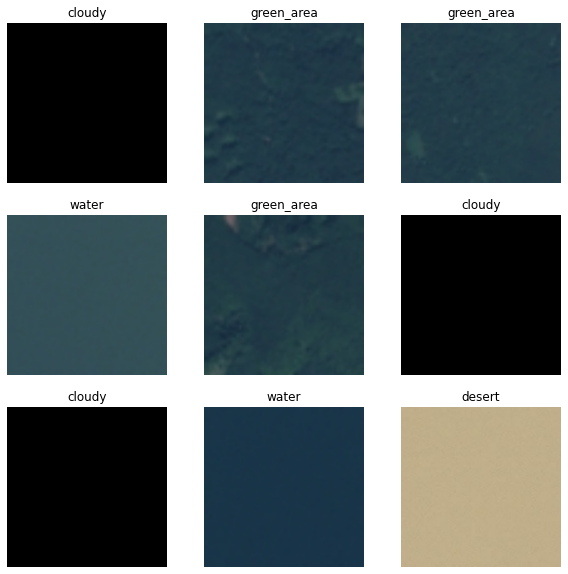

In [5]:
train_dataset = image_dataset_from_directory('../input/satellite-image-classification/data',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [6]:
#call ResNet model
res_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=k.Input(shape=(224,224,3)),
)
for models in res_model.layers[:-1]:
      models.trainable= False
model = k.models.Sequential()
model.add(res_model)
model.add(k.layers.Flatten())
model.add(k.layers.Dense(4, activation='softmax'))
print(model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 401412    
Total params: 23,989,124
Trainable params: 401,412
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [7]:
model.compile(optimizer="adam", loss=k.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [8]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [9]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 50)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
124/124 [==============================] - 563s 5s/step - loss: 4.4631 - accuracy: 0.2503 - val_loss: 1.5280 - val_accuracy: 0.5181
Epoch 2/50
124/124 [==============================] - 561s 5s/step - loss: 1.3545 - accuracy: 0.4124 - val_loss: 0.9692 - val_accuracy: 0.5453
Epoch 3/50
124/124 [==============================] - 563s 5s/step - loss: 1.0967 - accuracy: 0.5242 - val_loss: 1.0953 - val_accuracy: 0.3677
Epoch 4/50
124/124 [==============================] - 568s 5s/step - loss: 1.0231 - accuracy: 0.5754 - val_loss: 1.0561 - val_accuracy: 0.5192
Epoch 5/50
124/124 [==============================] - 565s 5s/step - loss: 1.0403 - accuracy: 0.5446 - val_loss: 0.8450 - val_accuracy: 0.5370
Epoch 6/50
124/124 [==============================] - 541s 4s/step - loss: 0.8686 - accuracy: 0.6294 - val_loss: 0.6162 - val_accuracy: 0.7407
Epoch 7/50
124/124 [==============================] - 562s 5s/step - loss: 0.6423 - accuracy: 0.7515 - val_loss: 0.8425 - val_accuracy: 0.6862

In [10]:
model.evaluate(test_generator)

53/53 [==============================] - 181s 3s/step - loss: 0.4600 - accuracy: 0.8496


[0.45999836921691895, 0.8496151566505432]

In [11]:
#classes names 
class_name = {0:"cloud",1:"desert" , 2 : 'green_area', 3: 'water'}

In [12]:
#predict test data
y = model.predict(test_generator)
y =  np.argmax(y,axis= 1 )

In [13]:
#y_true and y_pred
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_generator:
    i += 1
    y = np.argmax(model.predict(data), axis=1)
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y)
  
    if i == test_generator.samples // 32 + 1:
        break

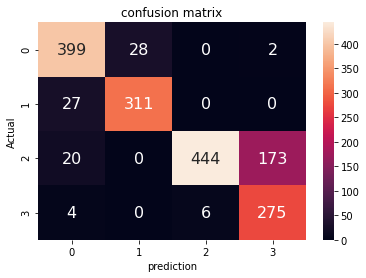

In [14]:
cm  = confusion_matrix(y_pred,y_true)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
seaborn .heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

In [15]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       429
         1.0       0.92      0.92      0.92       338
         2.0       0.99      0.70      0.82       637
         3.0       0.61      0.96      0.75       285

    accuracy                           0.85      1689
   macro avg       0.85      0.88      0.85      1689
weighted avg       0.88      0.85      0.85      1689



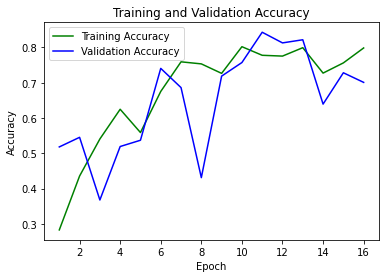

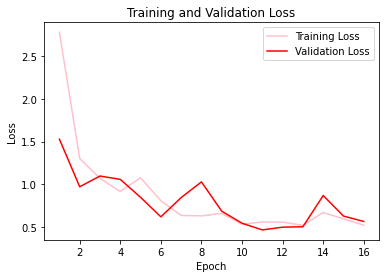

In [16]:
#plot the result
import matplotlib.pyplot as plt
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
model.save('res_model.h5')